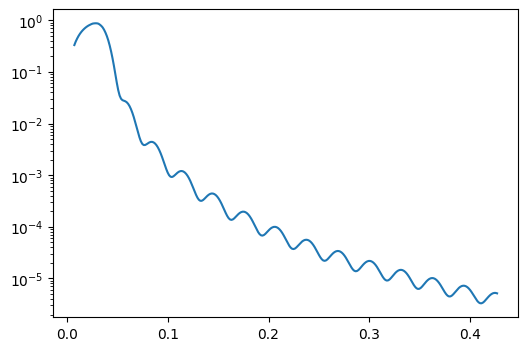

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from genx.plugins.add_ons.help_modules.frequency_analysis import TransformType, transform

from reflecto.simulate.simul_genx import ParamSet, params2refl, tth2q_wavelen

wavelen: float = 1.54  # (nm)
tth_min: float = 0.1   # degree
tth_max: float = 6.0
tth_n: int = 300
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

# xrr_simulator = XRRSimulator(qs, 2, 1)
# thicknesses, roughnesses, slds, refl = next(xrr_simulator.make_params_refl())
# params = [ParamSet(70, 0, 1), ParamSet(40, 0, 1)]
params = [ParamSet(200, 0, 1)]
refl = params2refl(params, qs)
# print(f"thicknesses: {thicknesses}, roughnesses: {roughnesses}, slds: {slds}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

In [60]:
from scipy.signal import savgol_filter


def find_qc_derivative(q, I, smooth_window=11, plot=False):
    """
    미분을 이용한 Qc 찾기 (가장 정확한 방법)
    전반사가 끝나고 급격히 떨어지는 지점이 Qc
    
    Parameters:
    -----------
    q : array
        Q 벡터 (Å⁻¹)
    I : array
        반사 강도
    smooth_window : int
        스무딩 윈도우 크기 (홀수)
    plot : bool
        결과 플롯 여부
        
    Returns:
    --------
    qc : float
        임계 Q 값
    """
    # 로그 스케일로 변환 (더 선명한 변화)
    log_I = np.log10(np.maximum(I, I[I > 0].min()))

    # 스무딩
    log_I_smooth = savgol_filter(log_I, smooth_window, 3)

    # 1차 미분
    dI_dq = np.gradient(log_I_smooth, q)

    # 2차 미분 (변곡점 찾기)
    d2I_dq2 = np.gradient(dI_dq, q)

    # Qc는 2차 미분이 최소인 지점 (가장 급격히 떨어지는 곳)
    # 낮은 Q 영역에서만 찾기 (일반적으로 0.1 Å⁻¹ 이하)
    low_q_mask = q < 0.1
    qc_idx = np.argmin(d2I_dq2[low_q_mask])
    qc = q[low_q_mask][qc_idx]

    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))

        # 원본 데이터
        axes[0].semilogy(q, I, 'b-', alpha=0.5, label='Original')
        axes[0].semilogy(q, 10**log_I_smooth, 'r-', label='Smoothed')
        axes[0].axvline(qc, color='g', linestyle='--', linewidth=2, label=f'Qc = {qc:.4f} Å⁻¹')
        axes[0].set_xlabel('Q (Å⁻¹)')
        axes[0].set_ylabel('Intensity')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].set_title('Reflectivity Data')

        # 1차 미분
        axes[1].plot(q, dI_dq, 'b-')
        axes[1].axvline(qc, color='g', linestyle='--', linewidth=2)
        axes[1].set_xlabel('Q (Å⁻¹)')
        axes[1].set_ylabel('dlog(I)/dQ')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_title('First Derivative')

        # 2차 미분
        axes[2].plot(q, d2I_dq2, 'r-')
        axes[2].axvline(qc, color='g', linestyle='--', linewidth=2, label=f'Min at Qc = {qc:.4f}')
        axes[2].set_xlabel('Q (Å⁻¹)')
        axes[2].set_ylabel('d²log(I)/dQ²')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        axes[2].set_title('Second Derivative (finds inflection point)')
        axes[2].set_xlim(0, min(0.15, q.max()))

        plt.tight_layout()
        plt.show()

    return qc

qc = find_qc_derivative(qs, refl)
qc

np.float64(0.04224905524362292)

Peak 위치 (x값): [ 181.04287959  995.73583772 1719.90735606 2534.6003142  3168.25039275
 3801.90047129 3982.94335088 4163.98623047]
200


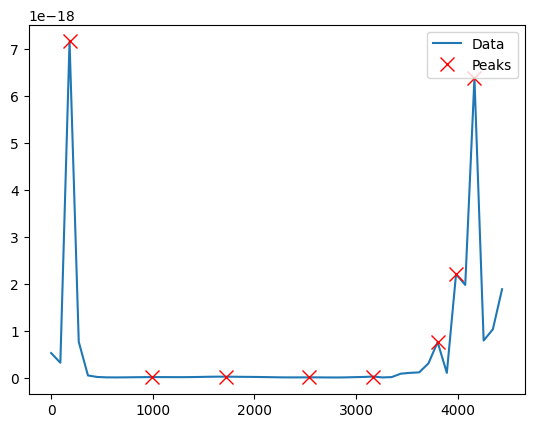

In [73]:
thickness = 200
params = [ParamSet(thickness, 3, 1)]
refl = params2refl(params, qs)
D, T = transform(
    qs, refl,
    trans_type=TransformType.mexican_hat_WT,  # Wavelet 변환
    Qc=qc,
    Q4=True,
    logI=False,              # 로그 스케일
    Qmin=qs[0],              # 낮은 Q 제거
    Qmax=qs[-1],               # 높은 Q 제거
    wavelet_scaling=0.6,     # Wavelet 스케일링
    avg_correction=None
)

from scipy.signal import find_peaks

peaks, properties = find_peaks(T)
print(f"Peak 위치 (x값): {D[peaks]}")
print(thickness)
plt.plot(D, T, label='Data')
plt.plot(D[peaks], T[peaks], 'rx', markersize=10, label='Peaks')
plt.legend()
plt.show()

plt.show()

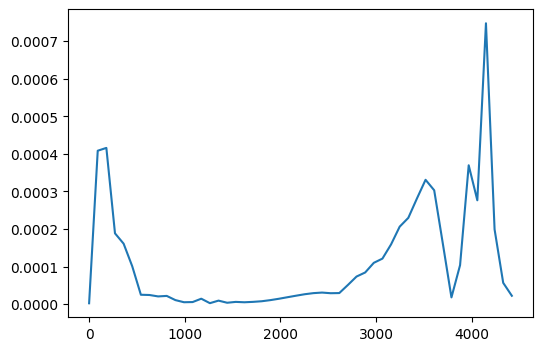

In [66]:
D, T = transform(qs, refl,
                 Qc=0.02,     # 임계 Q 보정
                 Q4=True,      # Fresnel 보정
                 derivate=True # 미분으로 평탄화 제거
                )
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(D, T)
# ax.set_yscale("log")


plt.show()

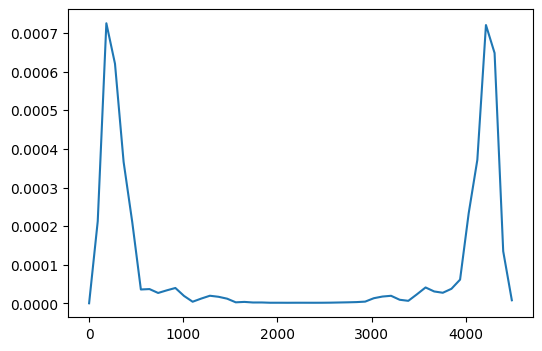

In [67]:
D, T = transform(
    qs, refl,
    avg_correction='subtract',  # 또는 'divide'
    avgN=20,                     # 평균 계산 점 개수
    Q4=True,
    derivate=True
)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(D, T)
# ax.set_yscale("log")

plt.show()

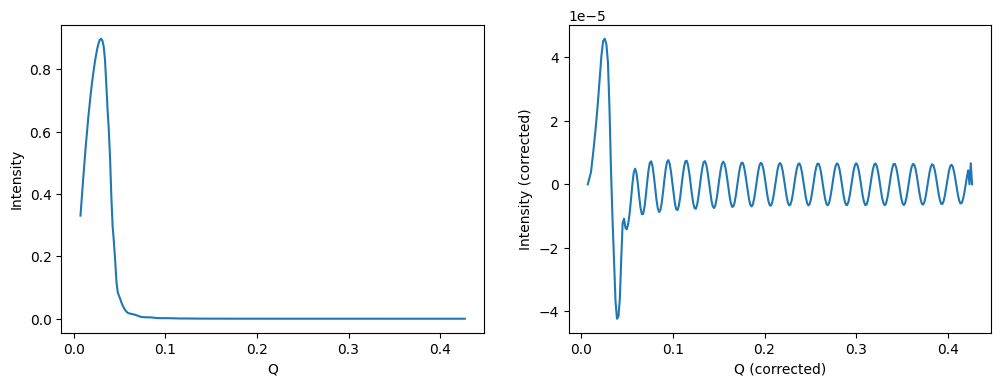

In [68]:
Q_corrected, I_corrected, D, T = transform(
    qs, refl,
    Qc=0.02,
    Q4=True,
    derivate=True,
    return_corrected=True  # 보정된 Q, I도 반환
)

# 보정 전후 비교
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(qs, refl, label='Original')
plt.xlabel('Q')
plt.ylabel('Intensity')

plt.subplot(122)
plt.plot(Q_corrected, I_corrected, label='Corrected')
plt.xlabel('Q (corrected)')
plt.ylabel('Intensity (corrected)')
# plt.yscale("log")
plt.show()